In [1]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
users_eng = pd.read_csv('takehome_user_engagement.csv', index_col = 'time_stamp', parse_dates=['time_stamp'])
#users_eng['time_stamp'] = pd.to_datetime(users_eng['time_stamp'])
users = pd.read_csv('takehome_users.csv', encoding='latin-1')

In [3]:
users_eng = users_eng.sort_index()
users_eng.index

DatetimeIndex(['2012-05-31 08:20:06', '2012-05-31 15:47:36',
               '2012-05-31 17:19:37', '2012-05-31 21:58:33',
               '2012-06-01 00:17:30', '2012-06-01 01:42:31',
               '2012-06-01 13:14:18', '2012-06-01 14:30:38',
               '2012-06-01 20:02:35', '2012-06-01 21:49:51',
               ...
               '2014-06-04 23:13:01', '2014-06-04 23:14:30',
               '2014-06-04 23:21:13', '2014-06-04 23:28:26',
               '2014-06-04 23:30:50', '2014-06-04 23:32:13',
               '2014-06-04 23:34:04', '2014-06-04 23:46:31',
               '2014-06-04 23:56:26', '2014-06-06 14:58:50'],
              dtype='datetime64[ns]', name='time_stamp', length=207917, freq=None)

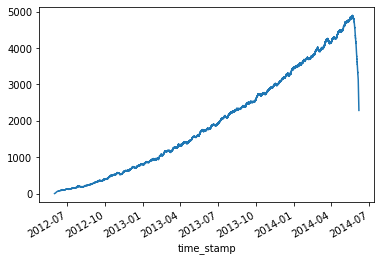

In [4]:
total_7d_visits = users_eng.rolling('7D').visited.count()

#total visits to the site have been steadily increasing since 2012, but dropped sometime in the spring of 2014
total_7d_visits.plot()

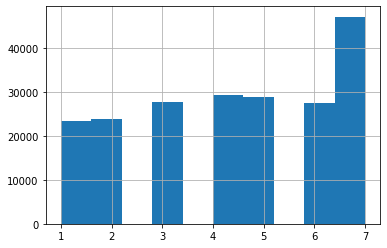

In [5]:
#the distribution of visits is fairly equal except for "heavy" users that visit more than 6 times in 7 days
visits_by_user = users_eng.groupby('user_id').rolling('7D').visited.count()
visits_by_user.hist()

### Generating Features from Time Series

In [6]:
#the number of counts per 7d range will allow for filtering of users into adopted and not adopted
df_7d_count = pd.DataFrame(visits_by_user)
df_7d_count = df_7d_count.rename(columns={"visited":"visit_count_7d"})
df_7d_average = pd.DataFrame(users_eng.groupby('user_id').rolling('7D').visited.mean())
df_7d_average = df_7d_average.rename(columns={"visited":"visit_average_7d"})

df_14d_count = pd.DataFrame(users_eng.groupby('user_id').rolling('14D').visited.count())
df_14d_count = df_14d_count.rename(columns={"visited":"visit_count_14d"})
df_14d_average = pd.DataFrame(users_eng.groupby('user_id').rolling('14D').visited.mean())
df_14d_average = df_14d_average.rename(columns={"visited":"visit_average_14d"})

df_30d_count = pd.DataFrame(users_eng.groupby('user_id').rolling('30D').visited.count())
df_30d_count = df_30d_count.rename(columns={"visited":"visit_count_30d"})
df_30d_average = pd.DataFrame(users_eng.groupby('user_id').rolling('30D').visited.mean())
df_30d_average = df_30d_average.rename(columns={"visited":"visit_average_30d"})

In addition to 7d counts being calculated to define adopted users, the average hits over 7d periods were calculated as a possible predictive feature. The window was also expanded to 14d and 30d to see if these parameters are predictive of adoption.

In [7]:
times = [df_7d_count, df_7d_average, df_14d_count, df_14d_average, df_30d_count, df_30d_average]
df_result = pd.concat(times, axis=1)
counts = df_result.groupby('user_id').count()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fad9814a4d0>]],
      dtype=object)

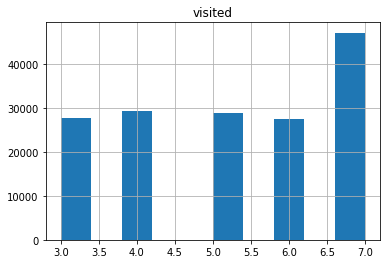

In [8]:
adopted_users = pd.DataFrame(visits_by_user[visits_by_user.values >= 3])
adopted_users.hist()

In [9]:
#while it is possible that frequency of visits is predictive of user adoption,
#more information will likely be found from the takehome users data

adopted_users.reset_index(inplace=True)
adopted_users.drop(['time_stamp','visited'], axis=1, inplace = True)
#creates column with True value for all user_ids defined as adopted
adopted_users['adopted'] = True
adopted_users = adopted_users.drop_duplicates(subset='user_id')
adopted_users = adopted_users.set_index('user_id')

In [10]:
adopted_counts = adopted_users.join(counts, how = 'left')

In [11]:
adopted_users.head()

,adopted
user_id,
2,True
10,True
20,True
33,True
42,True


In [12]:
#join timeseries data with user creation data
users.set_index('object_id', inplace=True)
user_data = users.join(counts, how = 'right')
user_data.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,visit_count_7d,visit_average_7d,visit_count_14d,visit_average_14d,visit_count_30d,visit_average_30d
user_id,,,,,,,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,1,1,1,1,1,1
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,14,14,14,14,14,14
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,1,1,1,1,1,1
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,1,1,1,1,1,1
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,1,1,1,1,1,1


In [13]:
#join adoption data with user creation data
df = user_data.join(adopted_users, how = 'left')
df['adopted'] = df['adopted'].fillna(False)

In [14]:
#get dummy variables for creation source, as this may be predictive of engagement
df = pd.get_dummies(data=df, columns=['creation_source'])

In [15]:
df.head()

,creation_time,name,email,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,visit_count_7d,visit_average_7d,visit_count_14d,visit_average_14d,visit_count_30d,visit_average_30d,adopted,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
user_id,,,,,,,,,,,,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,1.398139e+09,1,0,11,10803.0,1,1,1,1,1,1,False,1,0,0,0,0
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,1.396238e+09,0,0,1,316.0,14,14,14,14,14,14,True,0,1,0,0,0
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,1.363735e+09,0,0,94,1525.0,1,1,1,1,1,1,False,0,1,0,0,0
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,1.369210e+09,0,0,1,5151.0,1,1,1,1,1,1,False,1,0,0,0,0
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,1.358850e+09,0,0,193,5240.0,1,1,1,1,1,1,False,1,0,0,0,0


In [16]:
df.columns

Index(['creation_time', 'name', 'email', 'last_session_creation_time',
       'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id',
       'invited_by_user_id', 'visit_count_7d', 'visit_average_7d',
       'visit_count_14d', 'visit_average_14d', 'visit_count_30d',
       'visit_average_30d', 'adopted', 'creation_source_GUEST_INVITE',
       'creation_source_ORG_INVITE', 'creation_source_PERSONAL_PROJECTS',
       'creation_source_SIGNUP', 'creation_source_SIGNUP_GOOGLE_AUTH'],
      dtype='object')

In [18]:
#separate data into features (X) and labels (y)
X = df[[
       'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id',
       'invited_by_user_id', 'visit_count_7d', 'visit_average_7d','visit_count_14d', 'visit_average_14d',
       'visit_count_30d', 'visit_average_30d','creation_source_GUEST_INVITE',
       'creation_source_ORG_INVITE', 'creation_source_PERSONAL_PROJECTS',
       'creation_source_SIGNUP', 'creation_source_SIGNUP_GOOGLE_AUTH']]
y = df['adopted']

In [19]:
#the feature set contains NAN values for "invited_by_user_id" of account was not referred by a user
#these values set to 0, as there is no 0 user_id
X = X.fillna(0)

### Feature Analysis

In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#some algorithms perform better with scaled data, so StandarScaler used on features
X_scaled = scaler.fit_transform(X)

In [21]:
from sklearn.decomposition import PCA
pca = PCA()
pca_components = pca.fit(X_scaled)

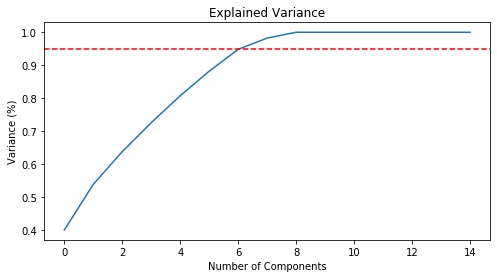

In [22]:
plt.figure(figsize=(8,4))

plt.plot(np.cumsum(pca_components.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.axhline(y=0.95, color='r',linestyle='--')
plt.title('Explained Variance')
plt.show()

From the explained variance graph above, we can see that around 95% of the variance in these data can be explained by 6 features. These are likely the features generated from the initial timeseries analysis.

Feature: 0, Score: -0.01067
Feature: 1, Score: -0.01205
Feature: 2, Score: 0.12087
Feature: 3, Score: 0.03866
Feature: 4, Score: 6.42603
Feature: 5, Score: 6.42603
Feature: 6, Score: 6.42603
Feature: 7, Score: 6.42603
Feature: 8, Score: 6.42603
Feature: 9, Score: 6.42603
Feature: 10, Score: -0.02162
Feature: 11, Score: -0.02000
Feature: 12, Score: 0.04479
Feature: 13, Score: -0.01390
Feature: 14, Score: 0.03032


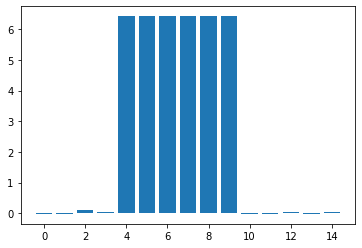

In [23]:
from sklearn.linear_model import LogisticRegression

m = LogisticRegression()
m.fit(X_scaled,y)

importance = m.coef_[0]
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Logistic regression was used as a first pass because of its simplicity and speed, from this we see that the features most predictive of adoption are indeed the usage statistics mined from the user interaction. However there is some significance to the second feature in the dataset, the organization that the user belongs to.

Feature: 0, Score: 0.00496
Feature: 1, Score: 0.00331
Feature: 2, Score: 0.04608
Feature: 3, Score: 0.02303
Feature: 4, Score: 0.13366
Feature: 5, Score: 0.18252
Feature: 6, Score: 0.15267
Feature: 7, Score: 0.11078
Feature: 8, Score: 0.18144
Feature: 9, Score: 0.15010
Feature: 10, Score: 0.00264
Feature: 11, Score: 0.00248
Feature: 12, Score: 0.00154
Feature: 13, Score: 0.00252
Feature: 14, Score: 0.00226


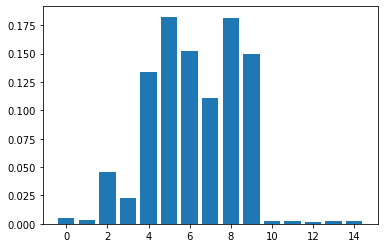

In [24]:
from sklearn.ensemble import RandomForestClassifier

m = RandomForestClassifier()
# fit the model
m.fit(X, y)

# get importance
importance = m.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

The same pattern is observed when a random forest classifier is used to analyze the feature importance, but with the addition that who invited the user may also play some factor.

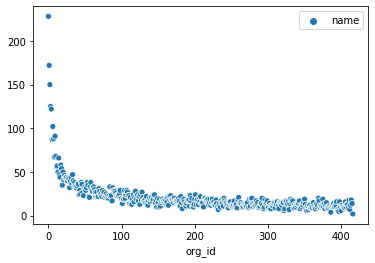

In [44]:
org = pd.DataFrame(df.groupby('org_id').name.count())
sns.scatterplot(data = org)

From this scatterplot you can see that most users do not belong to an organization, but there are many users that belong to organizations with an id below 25 or so. Belonging to one of these user organizations may be predictive of adoption.

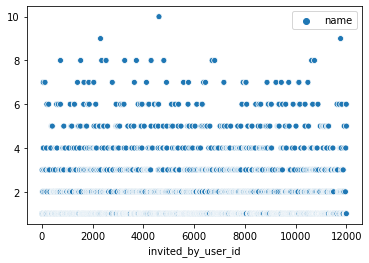

In [54]:
invite = pd.DataFrame(df.groupby('invited_by_user_id').name.count())
sns.scatterplot(data = invite)

This scatterplot shows that while some users invite more users than others, there is not a clear pattern of users that have been invited adopting the service.

### Conclusions

From these data I would recommend that further analysis be performed on the user groups that users belong to. It is clear that belonging to some of these groups is somewhat predictive of user adoption, so identifying what these groups are and how they use the service will be informative. 